This is a combination of comprehensive tutorials from gammapy of doing 1D Spectral Analysis and to plot the Light Curve, especially for our current use case.
One can follow the https://docs.gammapy.org/0.19/tutorials/analysis/1D/spectral_analysis.html and https://docs.gammapy.org/0.19/tutorials/analysis/time/light_curve.html for more general tutorial from gammapy.

# This example notebook, converts the provided DL3 files (with global cuts) into Spectrum Dataset objects and the Fits a simple Spectral Model to the dataset to plot Light Curve and SED:

## 1. Read the provided DL3 index files
## 2. Apply selection filters to the list of DL3 files
## 3. Define base geometry for the 1D spectrum
## 4. Generate some dataset makers for data reduction
## 5. Perform data reduction over all selected observations and compile them to a Dataset
## 6. Save the Dataset to OGIP files
## 7. Get the reference energy for a Log Parabola model Fit, by checking the Pivot energy for a Power law Fit
## 8. Perform Fitting, Modeling and check some statistics
## 9. Plot the LC and SED
## 10. Save SED and LC Flux Points, and Models to separate files 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import numpy as np
from regions import CircleSkyRegion, PointSkyRegion
from pathlib import Path
import os
import pickle

In [2]:
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator, FluxPoints
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.time import Time
import astropy.units as u

# 1. Parameters from user for selection of observations

In [3]:
# Use the DL3 files produced for source dependent or independent analyses
base_dir = "/fefs/aswg/workspace/analysis-school-2022/DL3/"
dir_path = base_dir + "Crab_src_indep/"

If the DL3 index files are not present, run the lstchain_create_dl3_index_files for the given DL3 files

!lstchain_create_dl3_index_files -d $dir_path --overwrite

In [4]:
total_datastore = DataStore.from_dir(dir_path)

ogip_path = Path(dir_path + 'OGIP/')

# Create the Paths if they do not exist already
ogip_path.mkdir(exist_ok=True)

# 2. Selection filters for the observations

In [5]:
# Get the object name from the OBS Table, assuming all the DL3 files are of the same single source.
# If not, then select a single object, to produce the relevant Spectrum Dataset file

obj_name = np.unique(total_datastore.obs_table["OBJECT"])[0]
print("The source is", obj_name)

max_zen = 30 # in deg for a maximum limit on zenith pointing of observations
min_time = 300 # in seconds for minimum livetime of each observation

The source is Crab


In [6]:
total_obs_list = total_datastore.obs_table["OBS_ID"].data
observations_total = total_datastore.get_observations(
    total_obs_list, 
    required_irf=["aeff", "edisp"], # By default, "all" = ["aeff", "edisp", "bkg", "psf"]. 
                        # If not all IRFs are present, the entry will be skipped 
    skip_missing=False # Skip missing observations, within the list provided earlier
)

No HDU found matching: OBS_ID = 2967, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2967, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2967, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2968, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2968, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2968, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2969, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2969, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2969, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2970, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2970, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2970, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2971, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2971, HDU_TYPE = bkg, HDU_CLA

In [7]:
# If you want to see the full Obs table, run this cell
total_datastore.obs_table

OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes6,int64,bytes5,bytes5
2967,2020-11-21,00:27:41.949,2020-11-21,00:47:39.583,83.97004257137505,22.24530742887652,29.732219820109158,60.26778017989084,95.17577361000707,83.63308333,22.0145,1605918461.948865,1605919659.583141,1196.639870882034,1197.634275913239,1149.988205508068,0.9610144484492402,Crab,WOBBLE,1,LST-1,LST-1
2968,2020-11-21,00:49:07.551,2020-11-21,01:08:52.833,83.26649188127247,21.78727828475309,24.644129286465912,65.35587071353409,100.4389391756115,83.63308333,22.0145,1605919747.551059,1605920932.833492,1182.285777568817,1185.282433271408,1134.331009923455,0.9594389372221211,Crab,WOBBLE,1,LST-1,LST-1
2969,2020-11-21,01:10:05.044,2020-11-21,01:29:48.847,83.97196330127397,22.24484450444434,20.576248490410606,69.4237515095894,103.5294881362074,83.63308333,22.0145,1605921005.043805,1605922188.846951,1181.815325260162,1183.803146123886,1132.395291687877,0.9581829474402809,Crab,WOBBLE,1,LST-1,LST-1
2970,2020-11-21,01:31:05.784,2020-11-21,01:50:48.103,83.26926193186183,21.78671531937169,15.806710775486678,74.19328922451332,112.7274981260833,83.63308333,22.0145,1605922265.783684,1605923448.10268,1180.322825431824,1182.31899523735,1129.404207074757,0.9568604306720593,Crab,WOBBLE,1,LST-1,LST-1
2971,2020-11-21,01:52:06.553,2020-11-21,02:11:57.547,83.97488474600792,22.24478141506711,11.974578308930873,78.02542169106913,120.7416399361625,83.63308333,22.0145,1605923526.552607,1605924717.547404,1189.995587110519,1190.994797468185,1137.239771866555,0.9556672177482076,Crab,WOBBLE,1,LST-1,LST-1
2972,2020-11-21,02:13:04.303,2020-11-21,02:32:51.148,83.26938274609692,21.78637577536815,8.456185607133747,81.54381439286625,145.5424713719346,83.63308333,22.0145,1605924784.303458,1605925971.14784,1185.846040725708,1186.84438252449,1132.911096118316,0.9553610310365438,Crab,WOBBLE,1,LST-1,LST-1
2973,2020-11-21,02:34:12.986,2020-11-21,02:53:58.082,83.97788837191327,22.24392982902823,6.650280392114226,83.34971960788577,175.3413477815111,83.63308333,22.0145,1605926052.986249,1605927238.082328,1184.09685921669,1185.096079111099,1131.106187027389,0.9552480257194873,Crab,WOBBLE,1,LST-1,LST-1
2974,2020-11-21,02:55:10.354,2020-11-21,03:15:02.371,83.2715938922083,21.78635039916637,8.551754635131715,81.44824536486828,215.4690377991381,83.63308333,22.0145,1605927310.353878,1605928502.371439,1191.018638849258,1192.017561435699,1137.902026660467,0.9554023669687387,Crab,WOBBLE,1,LST-1,LST-1


In [8]:
# If you want to see the full HDU table, run this cell
total_datastore.hdu_table

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME,SIZE
int64,bytes8,bytes8,bytes1,bytes26,bytes17,int64
2967,events,events,.,dl3_LST-1.Run02967.fits.gz,EVENTS,46273096
2967,gti,gti,.,dl3_LST-1.Run02967.fits.gz,GTI,46273096
2967,pointing,pointing,.,dl3_LST-1.Run02967.fits.gz,POINTING,46273096
2967,aeff,aeff_2d,.,dl3_LST-1.Run02967.fits.gz,EFFECTIVE AREA,46273096
2967,edisp,edisp_2d,.,dl3_LST-1.Run02967.fits.gz,ENERGY DISPERSION,46273096
2968,events,events,.,dl3_LST-1.Run02968.fits.gz,EVENTS,48726839
2968,gti,gti,.,dl3_LST-1.Run02968.fits.gz,GTI,48726839
2968,pointing,pointing,.,dl3_LST-1.Run02968.fits.gz,POINTING,48726839
2968,aeff,aeff_2d,.,dl3_LST-1.Run02968.fits.gz,EFFECTIVE AREA,48726839


# 3. Make selection of observations

In [9]:
d_wob = [total_datastore.obs_table["OBS_MODE"]=='WOBBLE']

d_time = [total_datastore.obs_table["LIVETIME"]>min_time]
d_zen = [total_datastore.obs_table["ZEN_PNT"]<max_zen]
d_obj = [total_datastore.obs_table["OBJECT"]==obj_name]

wob_obs_table = total_datastore.obs_table[d_wob[0]*d_zen[0]*d_obj[0]*d_time[0]]
wob_obs_list = total_datastore.obs_table[d_wob[0]*d_zen[0]*d_obj[0]*d_time[0]]["OBS_ID"]

observations_wob = total_datastore.get_observations(
    wob_obs_list.data, 
    required_irf=["aeff", "edisp"]
)

No HDU found matching: OBS_ID = 2967, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2967, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2967, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2968, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2968, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2968, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2969, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2969, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2969, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2970, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2970, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2970, HDU_TYPE = rad_max, HDU_CLASS = None
No HDU found matching: OBS_ID = 2971, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2971, HDU_TYPE = bkg, HDU_CLA

In [10]:
print('Wobble observation runs selected are:', wob_obs_list.data)
print(f'Total livetime of all observations: {total_datastore.obs_table["LIVETIME"].data.sum()/3600:.3f} hrs')
print(f'Total livetime of all selected wobble observations {wob_obs_table["LIVETIME"].data.sum()/3600:.3f} hrs')

Wobble observation runs selected are: [2967 2968 2969 2970 2971 2972 2973 2974 2975 2976 2977]
Total livetime of all observations: 3.461 hrs
Total livetime of all selected wobble observations 3.461 hrs


# 4. Define Target position and energy ranges for reconstructed events

In [11]:
target_position = SkyCoord.from_name(obj_name, frame='icrs')

In [12]:
# A long way to find the fixed global theta cut used for creating the IRFs

# Select the HDU entry of the first selected wobble observation
hdu_t = total_datastore.hdu_table
hdu_idx = np.where(hdu_t["OBS_ID"] == wob_obs_list[0])[0][0]

hdu_sel = hdu_t[hdu_idx]
print("Base directory of the HDU index file,", hdu_sel.meta["BASE_DIR"])
print("Location of the selected DL3 file, with respect to HDU index file,", hdu_sel["FILE_DIR"])
print("File name of the selected observation,", hdu_sel["FILE_NAME"])

file = Path(hdu_sel.meta["BASE_DIR"]) / hdu_sel["FILE_DIR"] / hdu_sel["FILE_NAME"]

theta_cut = Table.read(file, hdu="EFFECTIVE AREA").meta["RAD_MAX"]
print("Theta cut applied for creating the IRF in the selected DL3 file,", theta_cut)

# Converting the value into astropy.units
on_region_radius = u.Quantity(theta_cut)

Base directory of the HDU index file, /fefs/aswg/workspace/analysis-school-2022/DL3/Crab_src_indep
Location of the selected DL3 file, with respect to HDU index file, .
File name of the selected observation, dl3_LST-1.Run02967.fits.gz
Theta cut applied for creating the IRF in the selected DL3 file, 0.2 deg


In [13]:
# Provide the minimum, maximum energies in TeV units, and number of bins per decade, to create the 
# required reconstructed and true energy ranges.
# For Light Curve estimation and spectral fitting, flux calculation can be only performed within 
# the energy edges provided for the reconstructed events.
# For example, if the reconstructed energy edges are [0.01, 0.1, 1, 10] TeV and you want LC in 
# [0.05, 10] TeV energy range, then, reproduce the Dataset objects with those reconstructed energy edges.

e_reco_min = 0.01
e_reco_max = 40

e_true_min = 0.01
e_true_max = 100

# Using bins per decade
e_reco_bin_p_dec = 5
e_true_bin_p_dec = 10

energy_axis = MapAxis.from_energy_bounds(
    e_reco_min, e_reco_max, 
    nbin=e_reco_bin_p_dec, per_decade=True, 
    unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    e_true_min, e_true_max, 
    nbin=e_true_bin_p_dec, per_decade=True, 
    unit="TeV", name="energy_true"
)

# Select minimum and maximum energy edges for LC and SED, from the energy_axis to be used un the Dataset
# Here we use a different minimum energy than energy_axis, but the same energy bins.
# For analyzers who do not want energy bins per decade, or some custom bins for energy_axis, 
# make appropriate changes in each axis.
e_fit_min = energy_axis.edges[1].value
e_fit_max = energy_axis.edges[-1].value
e_fit_bin_p_dec = e_reco_bin_p_dec

# Just to have a separate MapAxis for spectral fit energy range
energy_fit_edges = MapAxis.from_energy_bounds(
    e_fit_min, e_fit_max, 
    nbin=e_fit_bin_p_dec, per_decade=True, 
    unit="TeV"
).edges

e_lc_min = energy_axis.edges[5]
e_lc_max = energy_axis.edges[-1]

print("Spectral Fit will be done in energy edges:\n", energy_fit_edges)
print("LC will be estimated from ", e_lc_min, "to ", e_lc_max)

Spectral Fit will be done in energy edges:
 [1.54732700e-02 2.39422086e-02 3.70464258e-02 5.73229351e-02
 8.86973254e-02 1.37243767e-01 2.12360986e-01 3.28591889e-01
 5.08439102e-01 7.86721553e-01 1.21731550e+00 1.88358515e+00
 2.91452217e+00 4.50971885e+00 6.97800975e+00 1.07972629e+01
 1.67068965e+01 2.58510321e+01 4.00000000e+01] TeV
LC will be estimated from  0.08869732536372837 TeV to  40.0 TeV


In [14]:
energy_axis_true.edges

<Quantity [1.00000000e-02, 1.25892541e-02, 1.58489319e-02, 1.99526231e-02,
           2.51188643e-02, 3.16227766e-02, 3.98107171e-02, 5.01187234e-02,
           6.30957344e-02, 7.94328235e-02, 1.00000000e-01, 1.25892541e-01,
           1.58489319e-01, 1.99526231e-01, 2.51188643e-01, 3.16227766e-01,
           3.98107171e-01, 5.01187234e-01, 6.30957344e-01, 7.94328235e-01,
           1.00000000e+00, 1.25892541e+00, 1.58489319e+00, 1.99526231e+00,
           2.51188643e+00, 3.16227766e+00, 3.98107171e+00, 5.01187234e+00,
           6.30957344e+00, 7.94328235e+00, 1.00000000e+01, 1.25892541e+01,
           1.58489319e+01, 1.99526231e+01, 2.51188643e+01, 3.16227766e+01,
           3.98107171e+01, 5.01187234e+01, 6.30957344e+01, 7.94328235e+01,
           1.00000000e+02] TeV>

In [15]:
# Get the GTI parameters of each observations to create time intervals for plotting LC
t_start = []
t_stop = []
tot_time = []

for obs in observations_wob:
    gti = obs.gti
    
    t_start.append(gti.time_start[0])
    t_stop.append(gti.time_stop[0])
    tot_time.append(gti.time_sum.value)

t_start = np.sort(np.array(t_start))
t_stop = np.sort(np.array(t_stop))
tot_time = np.array(tot_time)

t_start = Time(t_start)
t_stop = Time(t_stop)

t_day = np.unique(np.rint(t_start.mjd))

# To make the range night-wise, keep the MJD range in half integral values
t_range = [Time([t-0.5, t+0.5], format="mjd", scale="utc") for t in t_day]

# 5. Define the base Map geometries for creating the SpectrumDataset

In [16]:
on_region = CircleSkyRegion(
    target_position, 
    radius=on_region_radius
)

# This will create the base geometry in which to bin the events based on their reconstructed positions
on_geom = RegionGeom.create(
    on_region, 
    axes=[energy_axis]
)

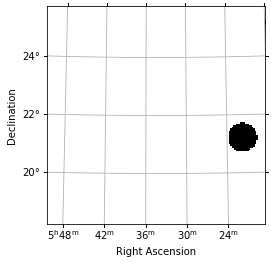

In [17]:
# Exclusion region/source for Crab - RGB J0521+212. 
# Can include specific close gamma-ray objects with respect to the given source, after looking at catalogs
# like http://gamma-sky.net/

# If need be, one can also modify the size of the region, in the previous cell, to exclude some regions
exclusion_region = CircleSkyRegion(
    center=SkyCoord.from_name("RGB J0521+212", frame="galactic"),
    radius=0.5 * u.deg,
)

skydir = target_position.galactic
excluded_geom = WcsGeom.create(
    npix=(150, 150), binsz=0.05, 
    skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~excluded_geom.region_mask([exclusion_region])
exclusion_mask.plot();
plt.grid()

# 6. Data Reduction chain

In [18]:
# Create some Dataset and Data Reduction Makers
# geom is the target geometry in reco energy for counts and background maps
# energy_axis_true is the true energy axis for the IRF maps
dataset_empty = SpectrumDataset.create(
    geom=on_geom, 
    energy_axis_true=energy_axis_true
)
# When not including a PSF IRF, put the containment_correction as False
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, 
    selection=["counts", "exposure", "edisp"]
)

In [19]:
# The following makers can be tuned and played to check the final Dataset to be used.

# Select the necessary number and size of the OFF regions, to be chosen by this method

bkg_maker = ReflectedRegionsBackgroundMaker(
    exclusion_mask=exclusion_mask,
    min_distance=1.5 * u.rad, # Minimum distance from input region
    max_region_number=1 # Maximum number of OFF regions
) 

# Can also include other parameters, by checking the documentation,
# https://docs.gammapy.org/0.19/api/gammapy.makers.ReflectedRegionsBackgroundMaker.html#gammapy.makers.ReflectedRegionsBackgroundMaker

In [20]:
# Maker for safe energy range for the events.
safe_mask_masker = SafeMaskMaker(
    methods=["aeff-max"], 
    aeff_percent=10
)

# Or make custom safe energy range for the events.
safe_min_energy = 50 * u.GeV
safe_max_energy = 20 * u.TeV
# For other arguments and options, check the documentation,
# https://docs.gammapy.org/0.19/api/gammapy.makers.SafeMaskMaker.html#gammapy.makers.SafeMaskMaker

# 7. Generate the Spectrum Dataset for all observations

In [21]:
%%time
# The final object will be stored as a Datasets object

# There will be an error message on use_region_center=False. It is a bug message in gammapy, so just ignore it
datasets = Datasets()

for obs_id, observation in zip(wob_obs_list, observations_wob):
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), 
        observation
    )
    print('obs_id:', obs_id)
    dataset_on_off = bkg_maker.run(
        dataset=dataset, 
        observation=observation
    )
    
    # Check the LC and SEDs by applying the safe mask to see the distinction.
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    
    # Or use custom safe energy range
    #dataset_on_off.mask_safe = dataset_on_off.counts.geom.energy_mask(
    #    energy_min=safe_min_energy, energy_max=safe_max_energy
    #)
    
    datasets.append(dataset_on_off)    

MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2967


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2968


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2969


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2970


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2971


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2972


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2973


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2974


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2975


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2976


MapMaker: use_region_center=False should not be used with point-like IRF. Results are likely inaccurate.


obs_id: 2977
CPU times: user 1min 44s, sys: 19.4 s, total: 2min 4s
Wall time: 2min 4s


In [22]:
print(datasets[0])

SpectrumDatasetOnOff
--------------------

  Name                            : 2967 

  Total counts                    : 2980 
  Total background counts         : 2114.00
  Total excess counts             : 866.00

  Predicted counts                : 2547.00
  Predicted background counts     : 2547.00
  Predicted excess counts         : nan

  Exposure min                    : 7.30e+04 m2 s
  Exposure max                    : 3.71e+08 m2 s

  Number of total bins            : 19 
  Number of fit bins              : 14 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 256.20

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 6373 
  Acceptance                      : 19 
  Acceptance off                  : 19 



# 8. Some plots with the given Dataset

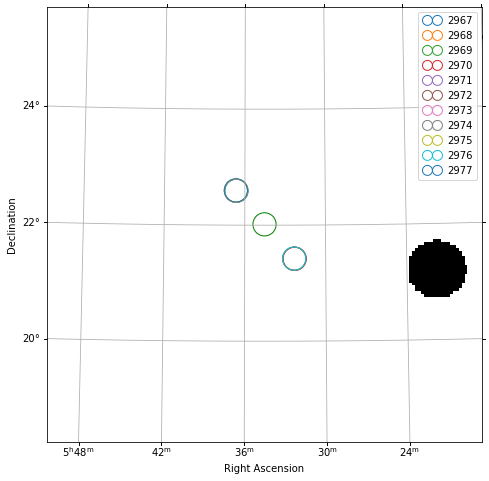

In [23]:
# Check the OFF regions used for calculation of excess
plt.figure(figsize=(8, 8))
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax)
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets, legend=True)
plt.grid()

# If need be, redo section 7 and 8, to be sure of the final dataset.
# This could be in the case of using source-dependent dataset

In [24]:
info_table = datasets.info_table(cumulative=True)
info_table

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,2980,2114.0,866.0,12.163095263658246,2547.0,2547.0,nan,72977.8984375,370646048.0,1150.9438431106662,1197.6342759132385,2.5891793225514177,1.836753385192516,0.752425937358902,19,14,wstat,256.20203197386917,2114,14.0,14.0,1.0
stacked,6024,4315.0,1709.0,16.84613659914232,5169.5,5169.5,nan,145084.71875,736868032.0,2288.1499611966356,2382.9167091846466,2.632694579532551,1.8858029732209427,0.7468916063116086,19,14,wstat,504.3791274628895,4315,14.0,14.0,1.0
stacked,9092,6618.0,2474.0,19.77954383724778,7855.0,7855.0,nan,217007.28125,1102154112.0,3422.449948938698,3566.7198553085327,2.656576468801079,1.9337024934585945,0.7228739753424845,19,14,wstat,730.8194150586186,6618,14.0,14.0,1.0
stacked,12202,9029.0,3173.0,21.81719854354231,10615.5,10615.5,nan,288740.53125,1466478720.0,4553.764211913265,4749.038850545883,2.679541458927081,1.982755272303935,0.6967861866231461,19,14,wstat,887.4987253197083,9029,14.0,14.0,1.0
stacked,15313,11486.0,3827.0,23.417580815824785,13399.5,13399.5,nan,360910.0625,1833019136.0,5691.9588963622755,5940.033648014069,2.6902864688264914,2.0179344596709385,0.672352009155553,19,14,wstat,1052.7762339798965,11486,14.0,14.0,1.0
stacked,18564,13914.0,4650.0,25.84669713059399,16239.0,16239.0,nan,432805.03125,2198164992.0,6825.823769330803,7126.878030538559,2.719671738876434,2.0384352819826925,0.6812364568937416,19,14,wstat,1261.1950232786796,13914,14.0,14.0,1.0
stacked,21670,16462.0,5208.0,26.7119322734397,19066.0,19066.0,nan,504585.625,2562729984.0,7957.884459189586,8311.974109649658,2.723085527457737,2.068640237794613,0.6544452896631239,19,14,wstat,1396.2070923495253,16462,14.0,14.0,1.0
stacked,24828,18850.0,5978.0,28.648806556492474,21839.0,21839.0,nan,576797.125,2929483520.0,9096.740858853556,9503.991671085358,2.729329150432567,2.0721707139380494,0.6571584364945178,19,14,wstat,1552.3666458034381,18850,14.0,14.0,1.0


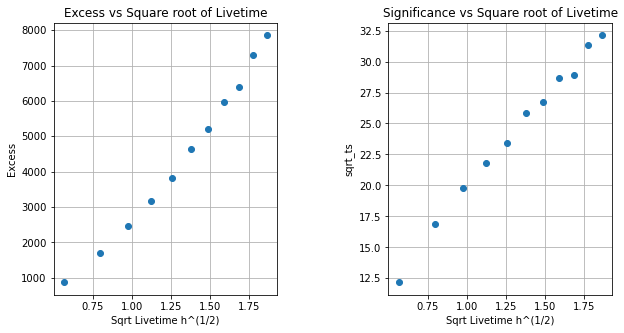

In [25]:
# Plot temporal evolution of excess events and significance value
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(
    np.sqrt(info_table["livetime"].to("h")), info_table["excess"], marker="o", ls="none"
)
plt.plot(info_table["livetime"].to("h")[-1:1], info_table["excess"][-1:1], 'r')
plt.xlabel("Sqrt Livetime h^(1/2)")
plt.ylabel("Excess")
plt.grid()
plt.title('Excess vs Square root of Livetime')

plt.subplot(122)
plt.plot(
    np.sqrt(info_table["livetime"].to("h")),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
plt.grid()
plt.xlabel("Sqrt Livetime h^(1/2)")
plt.ylabel("sqrt_ts")
plt.title('Significance vs Square root of Livetime')
plt.subplots_adjust(wspace=0.5)


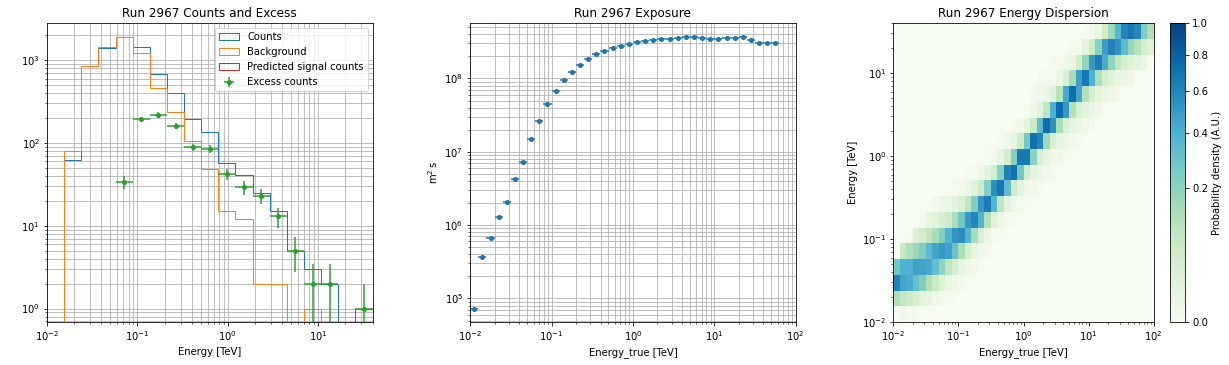

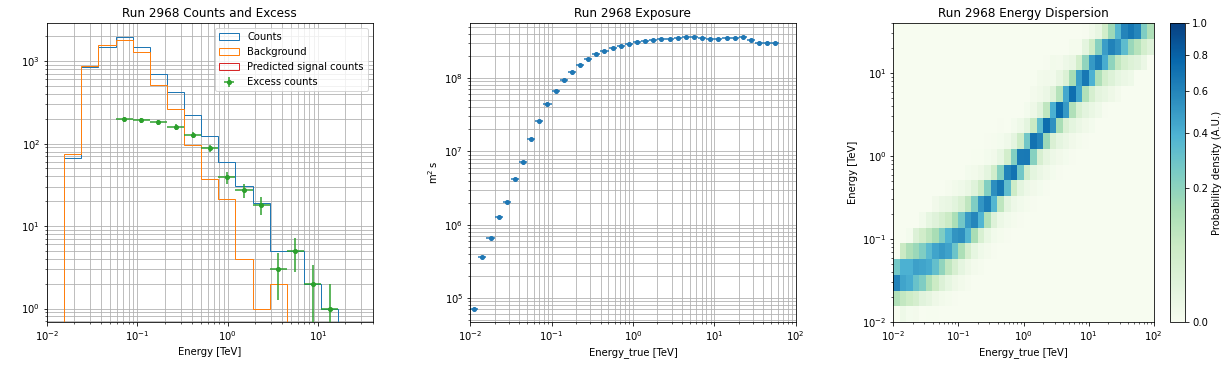

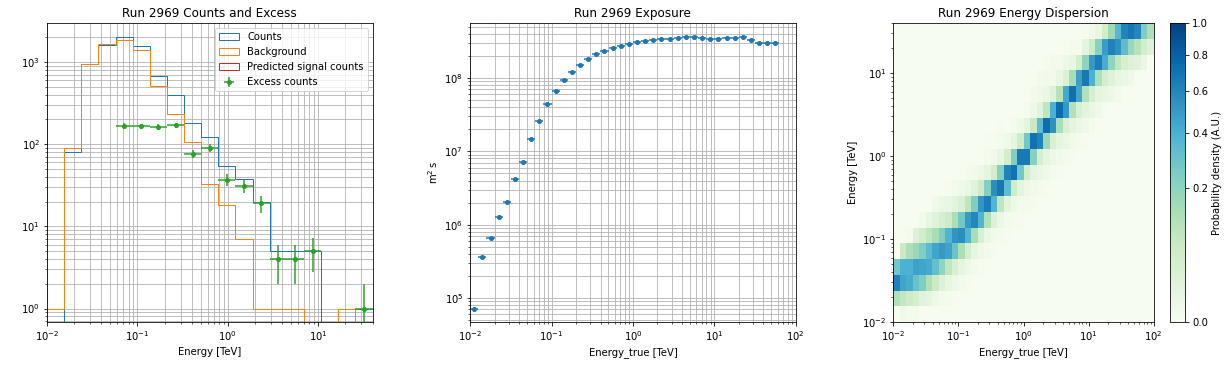

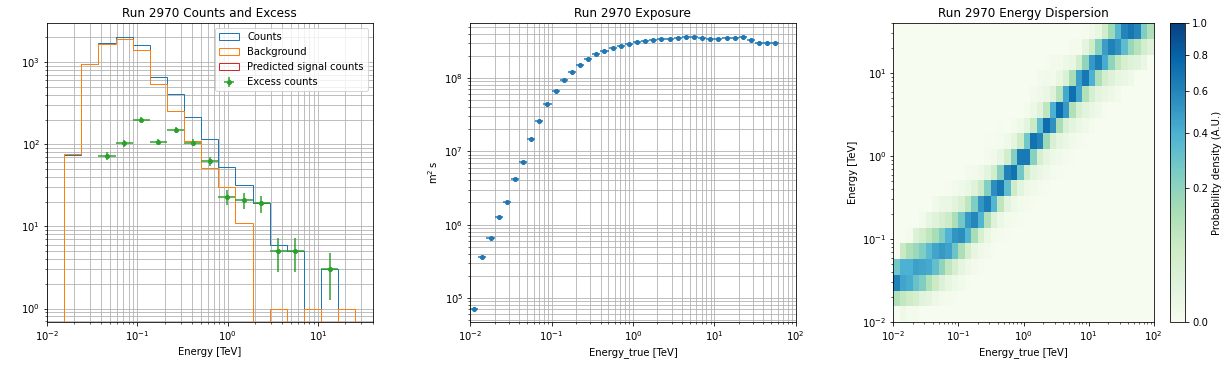

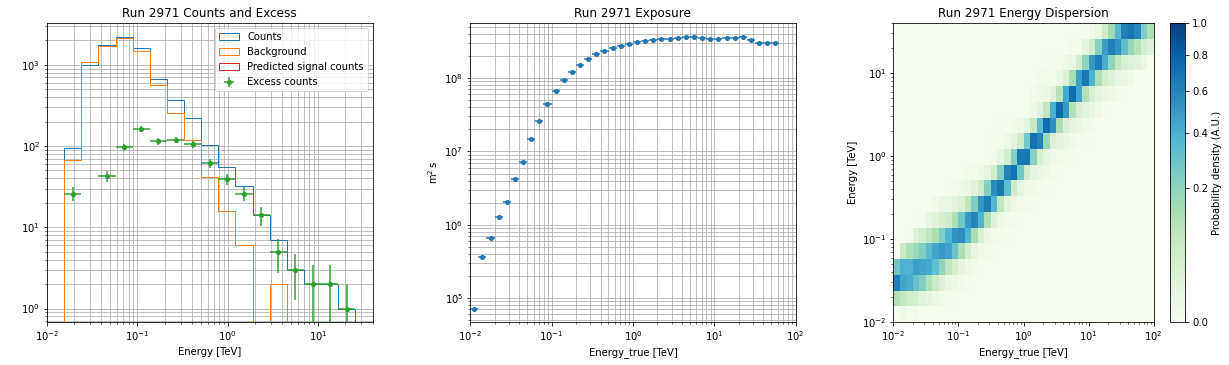

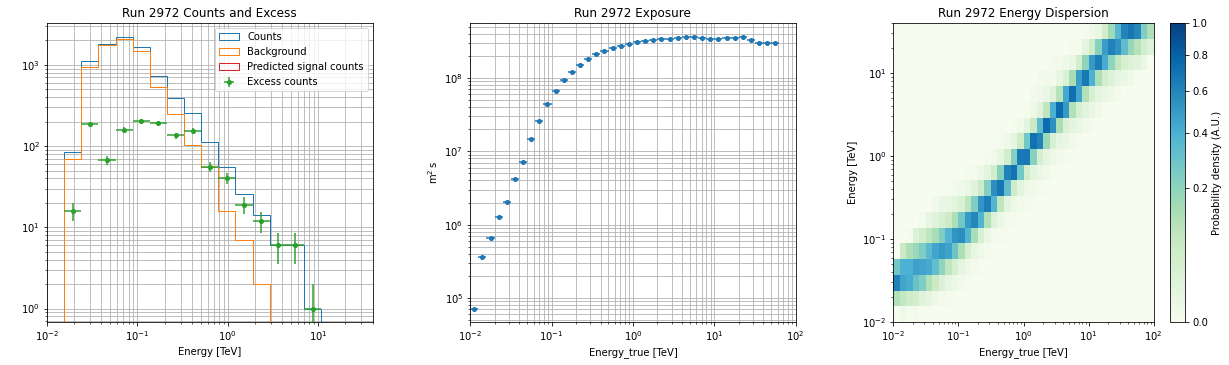

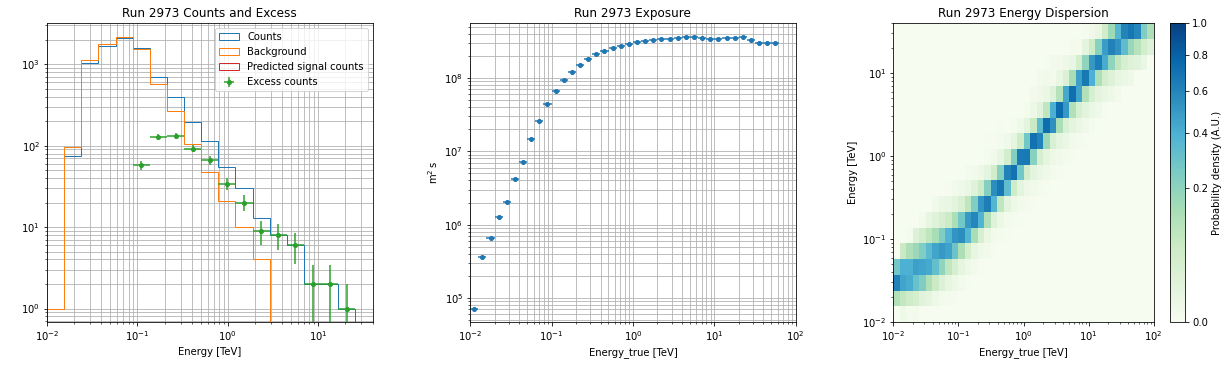

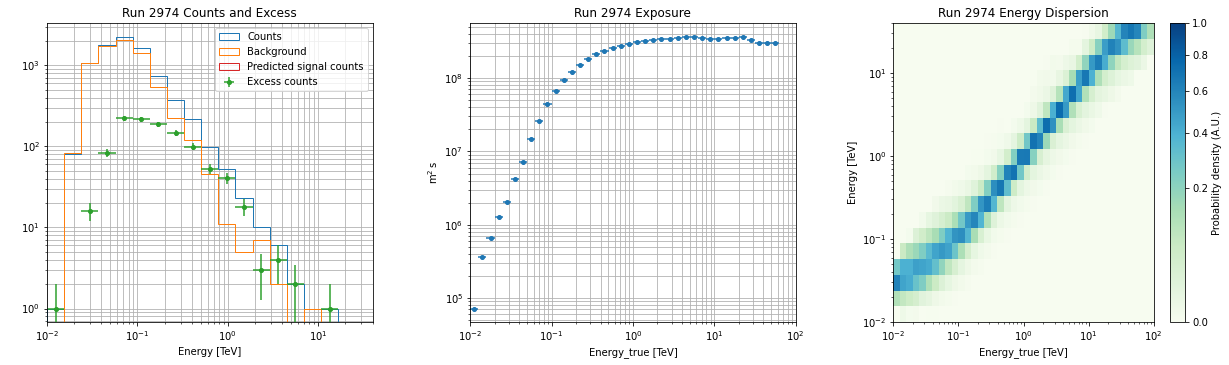

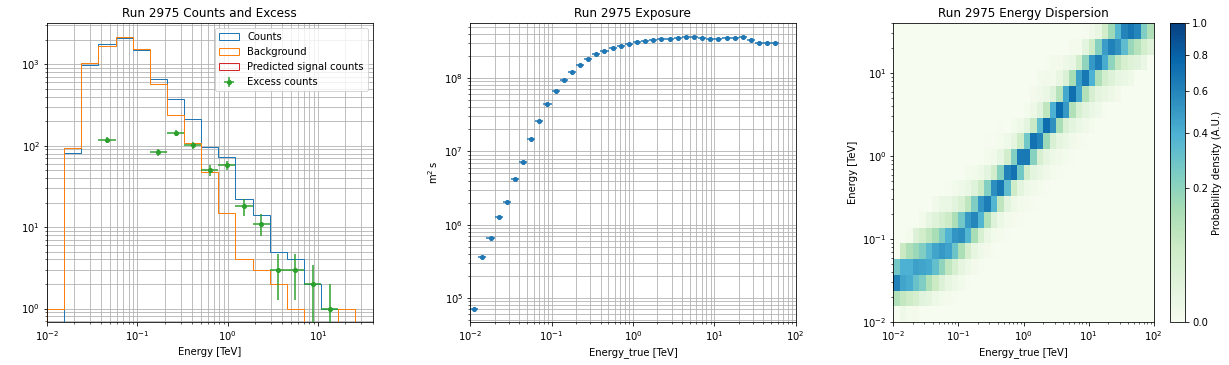

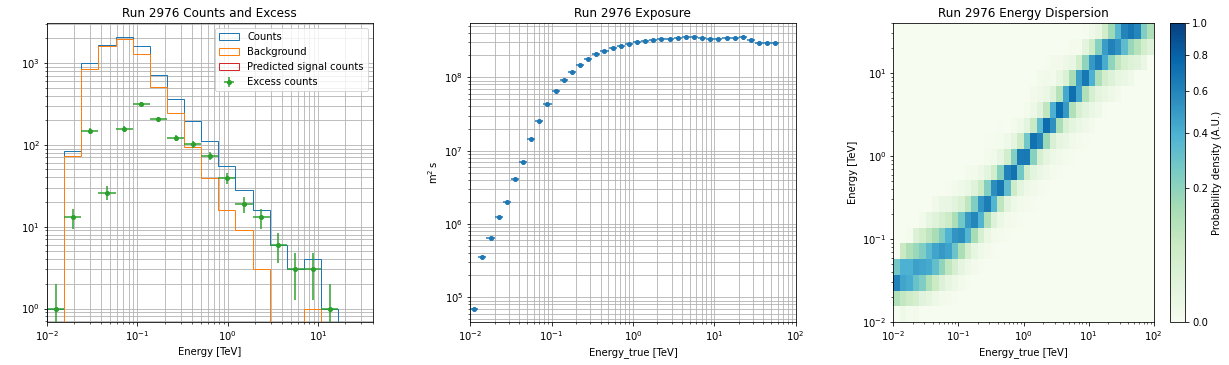

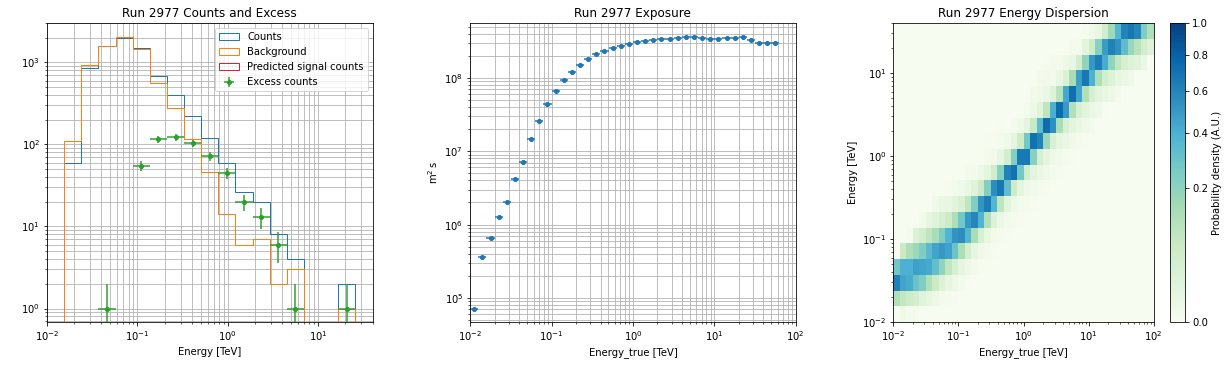

CPU times: user 20.3 s, sys: 2.75 s, total: 23 s
Wall time: 20.3 s


In [26]:
%%time
# Plot the counts+excess, exposure and energy migration of each selected dataset
for data in datasets:
    plt.figure(figsize=(21, 5.5))
    plt.subplot(131)
    data.plot_counts()
    data.plot_excess()
    plt.grid(which="both")
    plt.title(f'Run {data.name} Counts and Excess')
    
    plt.subplot(132)
    data.exposure.plot()
    plt.grid(which='both')
    plt.title(f'Run {data.name} Exposure')
    
    plt.subplot(133)
    if data.edisp is not None:
        kernel = data.edisp.get_edisp_kernel()
        kernel.plot_matrix(add_cbar=True)
        plt.title(f'Run {data.name} Energy Dispersion')
    plt.subplots_adjust(wspace=0.3)
    plt.show()
    plt.close()

# 9. Write all datasets into OGIP files

In [27]:
for d in datasets:
    d.write(
        filename=ogip_path / f"obs_{d.name}.fits.gz", overwrite=True
    )

In [28]:
# Read the OGIP files to include the source object name in its headers, to be used for further analysis
for obs in wob_obs_list:
    file = ogip_path/f"obs_{obs}.fits.gz"
    
    d1 = fits.open(file)
    d1.writeto(file, overwrite=True)

# 10. Get Pivot energy to fix the reference energy and define the Spectrum Model

In [29]:
# Find pivot (decorrelation) energy for a Power Law model to get the reference energy for Log Parabola model
def get_pivot_energy(datasets, e_ref, e_edges, obj_name):
    """
    Using Power Law spectral model with the given reference energy and 
    get the decorrelation energy of the fit, within the fit energy range, e_edges.
    This method is further explained in doi:10.1088/0004-637X/707/2/1310
    """
    spectral_model = PowerLawSpectralModel(
        index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=e_ref
    )
    model = SkyModel(spectral_model=spectral_model, name=obj_name)
    model_check = model.copy()

    # Stacked dataset method
    stacked_dataset = Datasets(datasets).stack_reduce()
    stacked_dataset.models = model_check

    fit_stacked = Fit()
    result_stacked = fit_stacked.run(datasets=stacked_dataset)

    return model_check.spectral_model.pivot_energy


In [30]:
# Using a reference energy close to the expected decorrelation energy
ref = get_pivot_energy(datasets, 0.4 * u.TeV, energy_axis.edges, obj_name)
print(ref.to_value(u.GeV))

475.7963713054805


In [31]:
# Final spectral model of Log Parabola, to be used for estimating the LC.
# One can try different Spectral Models as well.
# Be careful in the choice of Spectral Model being used for the 2 examples presented here

# Crab
spectral_model_lp = LogParabolaSpectralModel(
        amplitude = 5e-12 * u.Unit('cm-2 s-1 TeV-1'),
        reference = ref,
        alpha = 2 * u.Unit(''),
        beta = 0.1 * u.Unit('')
)
model_lp = SkyModel(spectral_model=spectral_model_lp, name=obj_name)


In [32]:
# Use the appropriate models, as per the selection of the source/dataset
params=model_lp.to_dict()['spectral']
params

{'type': 'LogParabolaSpectralModel',
 'parameters': [{'name': 'amplitude',
   'value': 5e-12,
   'unit': 'cm-2 s-1 TeV-1'},
  {'name': 'reference',
   'value': 0.47579637130548047,
   'unit': 'TeV',
   'frozen': True},
  {'name': 'alpha', 'value': 2.0},
  {'name': 'beta', 'value': 0.1}]}

# 11. Spectral Fitting
One can check for a more comprehensive tutorial on Modelling and Fitting, here are the gammapy tutorials -
* https://docs.gammapy.org/0.19/tutorials/api/fitting.html
* https://docs.gammapy.org/0.19/tutorials/api/model_management.html

In [33]:
# Using stacked analysis method, where we stack together all Datasets into 1 Dataset and add the model afterwards
stacked_dataset = Datasets(datasets).stack_reduce()
stacked_dataset.models = model_lp

In [34]:
# Fitting the model to the dataset
fit = Fit()
result = fit.run(datasets=stacked_dataset)
model_best = model_lp

In [35]:
# Compute the Flux Points after Fitting the model
# We do not do too many optimizations here. 
# If one wants, can try and check the various attributes of the Estimator
fpe = FluxPointsEstimator(
    energy_edges=energy_fit_edges, 
    reoptimize = False, # Re-optimizing other free model parameters (not belonging to the source)
    source=obj_name,
    selection_optional="all" # Estimates asymmetric errors, upper limits and fit statistic profiles
)
flux_points = fpe.run(datasets=stacked_dataset)

flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model_best
)

In [36]:
# Create the LC Estimator for each run and for each night
lc_maker_1d = LightCurveEstimator(
    energy_edges=[e_lc_min, e_lc_max], 
    reoptimize=False, # Re-optimizing other free model parameters (not belonging to the source)
    source=obj_name, 
    selection_optional="all" # Estimates asymmetric errors, upper limits and fit statistic profiles
)

lc_maker_night_wise = LightCurveEstimator(
    energy_edges=[e_lc_min, e_lc_max], 
    time_intervals=t_range,
    reoptimize=False, 
    source=obj_name,
    selection_optional="all"
)

# Assigning the best fit model for each dataset
for data in datasets:
    data.models = model_best

In [37]:
lc_1d = lc_maker_1d.run(datasets)
lc_night = lc_maker_night_wise.run(datasets)

In [38]:
result
# Gammapy bug, which will be fixed in the next release

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 224
	total stat : 7.79

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 224
	total stat : 7.79


In [39]:
model_best.to_dict()['spectral']['parameters']

[{'name': 'amplitude',
  'value': 1.7519084001064195e-10,
  'unit': 'cm-2 s-1 TeV-1',
  'error': 4.9491363270395216e-12},
 {'name': 'reference',
  'value': 0.47579637130548047,
  'unit': 'TeV',
  'frozen': True},
 {'name': 'alpha', 'value': 2.3253876159312132, 'error': 0.02675231187387204},
 {'name': 'beta', 'value': 0.06972420040078835, 'error': 0.017177062962929764}]

In [40]:
print(flux_points)

FluxPoints
----------

  geom                   : RegionGeom
  axes                   : ['lon', 'lat', 'energy']
  shape                  : (1, 1, 18)
  quantities             : ['norm', 'norm_err', 'norm_errn', 'norm_errp', 'norm_ul', 'ts', 'npred', 'npred_excess', 'stat', 'counts', 'success', 'stat_scan']
  ref. model             : lp
  n_sigma                : 1
  n_sigma_ul             : 2
  sqrt_ts_threshold_ul   : 2
  sed type init          : likelihood



# 12. Check some features of the Flux points

In [41]:
# Check the Flux table
# sed_type options are {“likelihood”, “dnde”, “e2dnde”, “flux”, “eflux”} with "likelihood" being default
# format options are {“gadf-sed”, “lightcurve”, “binned-time-series”, “profile”} with "gadf-sed" being default
flux_points.to_table(formatted=True, sed_type="e2dnde")

e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred [1],npred_excess [1],stat,is_ul,counts [1],success,norm_scan [11],stat_scan [11]
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,bool,float64,bool,float64,float64
0.019,0.015,0.024,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.030,0.024,0.037,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.046,0.037,0.057,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.071,0.057,0.089,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.110,0.089,0.137,5.594e-11,5.906e-12,5.905e-12,5.904e-12,6.775e-11,89.796,9.476,17163.99927984425,1710.9987,0.000,False,17164.0,True,0.200 .. 5.000,57.972 .. 1338.711
0.171,0.137,0.212,4.938e-11,3.376e-12,3.377e-12,3.375e-12,5.614e-11,214.481,14.645,7562.971053714933,1694.9486,0.000,False,7563.0,True,0.200 .. 5.000,134.507 .. 3293.626
0.264,0.212,0.329,4.749e-11,2.554e-12,2.556e-12,2.552e-12,5.261e-11,348.671,18.673,4293.992566858737,1558.9878,0.000,False,4294.0,True,0.200 .. 5.000,225.099 .. 4005.021
0.409,0.329,0.508,4.234e-11,2.175e-12,2.179e-12,2.171e-12,4.671e-11,386.098,19.649,2333.9757706746454,1153.9635,0.000,False,2334.0,True,0.200 .. 5.000,250.559 .. 3655.968


In [42]:
# Check the various column data of the Light Curve object
lc_1d.to_table(sed_type="flux", format="lightcurve")

time_min,time_max,e_ref [1],e_min [1],e_max [1],flux [1],flux_err [1],flux_errp [1],flux_errn [1],flux_ul [1],ts [1],sqrt_ts [1],"npred [1,11]","npred_excess [1,11]",stat [1],is_ul [1],"counts [1,11]",success [1],"norm_scan [1,11]","stat_scan [1,11]"
,,TeV,TeV,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,bool,float64,float64
59174.01970061281,59174.03356212063,1.8835851492696412,0.08869732536372837,40.000000000000014,6.190086591066929e-10,4.014571584145957e-11,4.025667162475535e-11,3.999001675812595e-11,6.998353502132781e-10,244.17602613475833,15.626132795249065,2971.2786555926655 .. nan,848.575439453125 .. nan,12.026005839110843,False,2980.0 .. nan,True,0.2 .. 4.999999999999999,181.69998166160636 .. 1661.6294760411045
59174.03458026783,59174.04829881451,1.8835851492696412,0.08869732536372837,40.000000000000014,6.155658154813973e-10,3.985634221178861e-11,4.0076778223321123e-11,3.964522739872437e-11,6.962605866941699e-10,249.86175756630578,15.807016086735212,nan .. nan,nan .. nan,6.319543513122863,False,nan .. nan,True,0.2 .. 4.999999999999999,180.28423039257805 .. 1625.0047019151696
59174.04913458202,59174.062836007324,1.8835851492696412,0.08869732536372837,40.000000000000014,5.718258164505206e-10,3.95478398196146e-11,3.9729180822088333e-11,3.9380136870381036e-11,6.516770496292854e-10,214.3987289511537,14.642360771103604,nan .. nan,nan .. nan,19.751792196793577,False,nan .. nan,True,0.2 .. 4.999999999999999,163.7367716427883 .. 1726.457480201294
59174.06372647877,59174.07741072641,1.8835851492696412,0.08869732536372837,40.000000000000014,5.053622991828533e-10,3.9581177907979054e-11,3.985414665930168e-11,3.9315287169863865e-11,5.858786820702255e-10,157.93602189781444,12.567259920038833,nan .. nan,nan .. nan,19.826771154176328,False,nan .. nan,True,0.2 .. 4.999999999999999,120.48725785305618 .. 1780.347225799408
59174.07831871167,59174.09210337368,1.8835851492696412,0.08869732536372837,40.000000000000014,4.950788963214261e-10,3.840740368730525e-11,3.8651351506749456e-11,3.8165809152852696e-11,5.728662420423181e-10,172.55982680512045,13.13620290666677,nan .. nan,nan .. nan,4.906653399289487,False,nan .. nan,True,0.2 .. 4.999999999999999,114.39645704122327 .. 1839.6455274009306
59174.09287601319,59174.10661263799,1.8835851492696412,0.08869732536372837,40.000000000000014,5.64141082876655e-10,4.055143361846528e-11,4.07899863857816e-11,4.031534070908156e-11,6.46209965551038e-10,207.58880151086225,14.407942306619022,nan .. nan,nan .. nan,14.345650905143946,False,nan .. nan,True,0.2 .. 4.999999999999999,152.63481152448685 .. 1657.0436848206919
59174.10755984179,59174.12127623159,1.8835851492696412,0.08869732536372837,40.000000000000014,4.771439614654352e-10,3.910975416745352e-11,3.934849472193148e-11,3.8979292163080166e-11,5.562912624987884e-10,146.47805842625598,12.102812004912577,nan .. nan,nan .. nan,7.772149657393815,False,nan .. nan,True,0.2 .. 4.999999999999999,98.02216053758508 .. 1838.978775480953
59174.12211270787,59174.13590920742,1.8835851492696412,0.08869732536372837,40.000000000000014,4.831373410661942e-10,3.927073516068818e-11,3.949391386025411e-11,3.905531370924863e-11,5.625675740940522e-10,162.37209682945158,12.74253102132585,nan .. nan,nan .. nan,15.661657526064479,False,nan .. nan,True,0.2 .. 4.999999999999999,115.10925887647188 .. 1822.6901496734288


In [43]:
# If there are more than 1 night of data, one can see the integrated light curve for each night
lc_night.to_table(sed_type="flux", format="lightcurve")

time_min,time_max,e_ref [1],e_min [1],e_max [1],flux [1],flux_err [1],flux_errp [1],flux_errn [1],flux_ul [1],ts [1],sqrt_ts [1],"npred [1,11]","npred_excess [1,11]",stat [1],is_ul [1],"counts [1,11]",success [1],"norm_scan [1,11]","stat_scan [1,11]"
,,TeV,TeV,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,bool,float64,float64
59173.50080074074,59174.50080074074,1.8835851492696412,0.08869732536372837,40.000000000000014,5.289799888051354e-10,1.1955253125676768e-11,1.197386041554485e-11,1.1936831667510232e-11,5.529652630301065e-10,2023.3534937068023,44.98170176534901,2894.4275238483024 .. 3126.159924692347,725.1586303710938 .. 712.2985229492188,172.84631794583697,False,2980.0 .. 3039.0,True,0.2 .. 4.999999999999999,1484.8227939916783 .. 19403.618021366343


In [44]:
# Fit Statistic array
print(flux_points_dataset.stat_array())

# Total statistics sum
print(flux_points_dataset.stat_sum(), np.nansum(flux_points_dataset.stat_array()))

[       nan        nan        nan        nan 0.02650376 0.37689857
 0.05627751 0.11436216 0.0752153  0.06607349 0.28517268 0.65162968
 2.17930533 0.3474357  0.06042133 1.21464425 2.24038512 0.10773006]
nan 7.802054945662438


In [45]:
# Add the Fit results to the model object to save it to file
model_final = model_best.to_dict()
model_final["FitResult"] = {
    "Optimize": result.optimize_result,
    "Covariance": result.covariance_result
}

In [46]:
model_final

{'name': 'Crab',
 'type': 'SkyModel',
 'spectral': {'type': 'LogParabolaSpectralModel',
  'parameters': [{'name': 'amplitude',
    'value': 1.7519084001064195e-10,
    'unit': 'cm-2 s-1 TeV-1',
    'error': 4.9491363270395216e-12},
   {'name': 'reference',
    'value': 0.47579637130548047,
    'unit': 'TeV',
    'frozen': True},
   {'name': 'alpha',
    'value': 2.3253876159312132,
    'error': 0.02675231187387204},
   {'name': 'beta',
    'value': 0.06972420040078835,
    'error': 0.017177062962929764}]},
 'FitResult': {'Optimize': OptimizeResult
  
  	backend    : minuit
  	method     : migrad
  	success    : True
  	message    : Optimization terminated successfully.
  	nfev       : 224
  	total stat : 7.79
  ,
  'Covariance': OptimizeResult
  
  	backend    : minuit
  	method     : migrad
  	success    : True
  	message    : Optimization terminated successfully.
  	nfev       : 224
  	total stat : 7.79
  }}

In [47]:
model_best.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str14,float64,float64,float64,bool,str1
spectral,amplitude,1.7519e-10,cm-2 s-1 TeV-1,4.949e-12,nan,nan,False,
spectral,reference,4.7580e-01,TeV,0.000e+00,nan,nan,True,
spectral,alpha,2.3254e+00,,2.675e-02,nan,nan,False,
spectral,beta,6.9724e-02,,1.718e-02,nan,nan,False,


# 13. Plots

In [48]:
if obj_name == 'Crab':
    ref_label="MAGIC LP (JHEAp 2015)"
else:
    ref_label="Crab MAGIC LP (JHEAp 2015)"

In [49]:
# Setting plot axes limits and other args

# Here we plot only in the energy range from where we have the first flux point, and before the first UL.
# This is based on the selection we used earlier on the dataset and the Flux points estimation we get.
# One should adjust the limit as per selections used earlier.

positive_flux = flux_points.to_table(formatted=True, sed_type="e2dnde")["e2dnde"] > 0
e_plot_min = flux_points.to_table(formatted=True, sed_type="e2dnde")["e_min"].quantity[positive_flux][0]

non_ul = flux_points.to_table(formatted=True, sed_type="e2dnde")["is_ul"] == 0
e_plot_max = flux_points.to_table(formatted=True, sed_type="e2dnde")["e_max"].quantity[non_ul][-1]

sed_kwargs = {
    "sed_type": "e2dnde",
    "energy_bounds": [e_plot_min, e_plot_max],
}

# Using the energy range used in the MAGIC reference
ds_magic_ref_kwargs = {
    "sed_type": "dnde",
    "energy_bounds": [50 * u.GeV, 30 * u.TeV],
}
sed_magic_ref_kwargs = {
    "sed_type": "e2dnde",
    "energy_bounds": [50 * u.GeV, 30 * u.TeV],
}
lc_kwargs = {
    "marker": "o", 
    "label": "LST-1"
}
sed_plot_kwargs = {
    "label": "LST-1 data",
}
plot_ts_kwargs = {
    "color": "darkorange"
}

In [50]:
# Calculate & plot Crab reference flux
# https://doi.org/10.1016/j.jheap.2015.01.002
crab = create_crab_spectral_model("magic_lp")
crab.amplitude.error = 0.03e-11 * u.Unit("cm-2 s-1 TeV-1")
crab.alpha.error = 0.01
crab.beta.error = 0.01/np.log(10)

flux_crab, flux_crab_error = crab.integral_error(e_lc_min, e_lc_max)
print(flux_crab, flux_crab_error)

5.45962180479239e-10 1 / (cm2 s) 1.273300031579829e-11 1 / (cm2 s)


/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


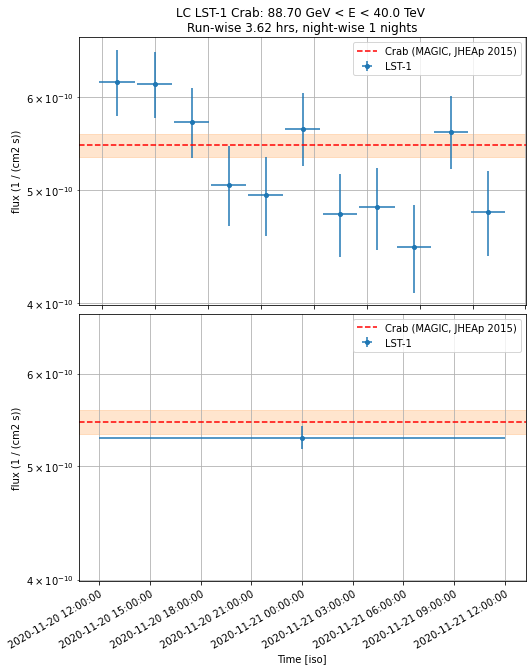

In [51]:
fig_lc = plt.figure(figsize=(8,10))

gs2 = GridSpec(10, 5)

gs2.update(wspace=0.4)
args1 = [gs2[:5,:]]
args2 = [gs2[5:,:]]

fig_gs1 = fig_lc.add_subplot(*args1)
fig_gs2 = fig_lc.add_subplot(*args2, sharey=fig_gs1)

lc_1d.plot(
    ax=fig_gs1,
    sed_type="flux",
    **lc_kwargs
)
fig_gs1.axhline(
    flux_crab.to_value("cm-2 s-1"), c='red', ls='--', 
    label='Crab (MAGIC, JHEAp 2015)'
)
fig_gs1.axhspan(
    (flux_crab - flux_crab_error).to_value("cm-2 s-1"), 
    (flux_crab + flux_crab_error).to_value("cm-2 s-1"), 
    alpha=0.2, color='tab:orange'
)
fig_gs1.get_xaxis().set_ticklabels([])
fig_gs1.grid(which='both')
fig_gs1.set_title(
    f'LC LST-1 {obj_name}: {e_lc_min.to(u.GeV):.2f} < E < {e_lc_max} \nRun-wise {tot_time.sum()/3600:.2f} hrs, night-wise {len(t_day)} nights'
)
fig_gs1.legend()
fig_gs1.get_yaxis().get_offset_text().set_position((-0.06,1))

lc_night.plot(
    ax=fig_gs2,
    sed_type="flux",
    axis_name="time",
    **lc_kwargs
)
fig_gs2.axhline(
    flux_crab.to_value("cm-2 s-1"), c='red', ls='--', 
    label='Crab (MAGIC, JHEAp 2015)'
)
fig_gs2.axhspan(
    (flux_crab - flux_crab_error).to_value("cm-2 s-1"), 
    (flux_crab + flux_crab_error).to_value("cm-2 s-1"), 
    alpha=0.2, color='tab:orange'
)

fig_gs2.grid(which='both')
fig_gs2.legend()

Text(0.5, 1.0, 'TS Profiles')

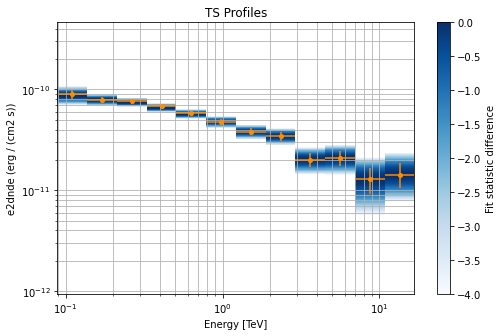

In [52]:
plt.figure(figsize=(8,5))
ax = flux_points.plot(sed_type="e2dnde", **plot_ts_kwargs)

flux_points.plot_ts_profiles(ax=ax, sed_type="e2dnde")
plt.xlim(e_plot_min.value, e_plot_max.value)

plt.grid(which='both')
plt.title('TS Profiles')

<AxesSubplot:>

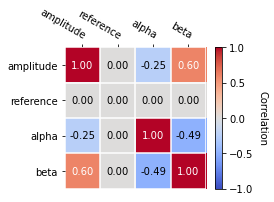

In [53]:
# Fit model covariance matrix plot
model_best.covariance.plot_correlation()

(0.08869732536372837, 16.706896483505616)

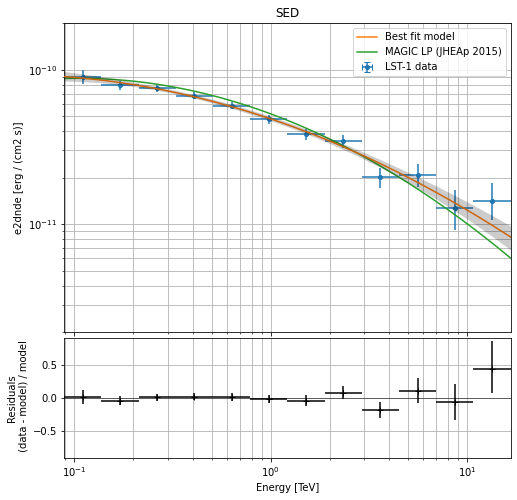

In [54]:
fig_sed = plt.figure(figsize=(8,8))

gs2 = GridSpec(7, 1)

gs2.update(hspace=0.1)
args1 = [gs2[:5,:]]
args2 = [gs2[5:,:]]

fig_gs1 = fig_sed.add_subplot(*args1)
fig_gs2 = fig_sed.add_subplot(*args2)

FluxPointsDataset(data=flux_points, models=model_best).plot_spectrum(
    ax=fig_gs1, 
    kwargs_fp=sed_plot_kwargs, 
)

create_crab_spectral_model("magic_lp").plot(
    ax=fig_gs1, **sed_magic_ref_kwargs, label=ref_label
)

fig_gs1.legend()
fig_gs1.set_xlim(e_plot_min.value, e_plot_max.value)
fig_gs1.set_ylim(2e-12, 2e-10)
fig_gs1.tick_params(labelbottom=False)

fig_gs1.grid(which='both')
fig_gs1.set_title('SED')

flux_points_dataset.plot_residuals(ax=fig_gs2, method='diff/model')
fig_gs2.grid(which='both')
fig_gs2.set_xlim(e_plot_min.value, e_plot_max.value)

Text(0, 0.5, 'Residuals \n (data-model)/sqrt(model)')

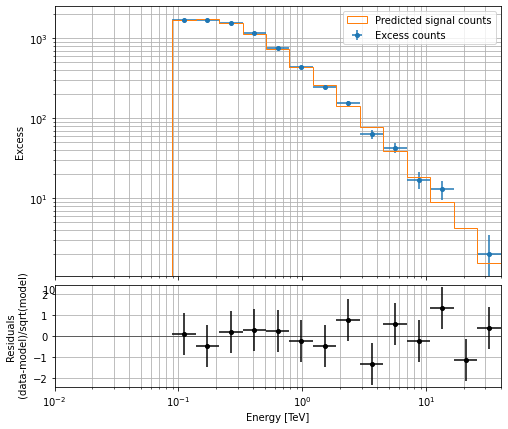

In [55]:
fig = plt.figure(figsize=(8,7))
gs = GridSpec(7, 1)

args1 = [gs[:5,:]]
args2 = [gs[5:,:]]
kwargs_res = {"method": "diff/sqrt(model)"}

fig_gs1 = fig.add_subplot(*args1)
fig_gs2 = fig.add_subplot(*args2)

stacked_dataset.plot_excess(fig_gs1)
fig_gs1.grid(which="both")
fig_gs1.set_ylabel("Excess")

stacked_dataset.plot_residuals_spectral(fig_gs2, **kwargs_res, region=stacked_dataset.counts.geom.region)
fig_gs2.grid(which="both")

fig_gs2.set_ylabel(f"Residuals \n (data-model)/sqrt(model)")

Text(0.5, 1.0, 'Differential spectrum')

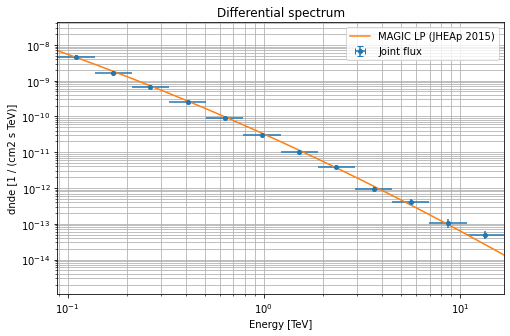

In [56]:
plt.figure(figsize=(8,5))

flux_points.plot(sed_type="dnde", label='Joint flux')
create_crab_spectral_model("magic_lp").plot(**ds_magic_ref_kwargs, label=ref_label)
plt.xlim(e_plot_min.value, e_plot_max.value)
plt.grid(which='both')
plt.legend()
plt.title('Differential spectrum')

# 14. Save the SED and LC Flux Points and Model to separate files
## This way, one can plot different SEDs and LCs together

In [57]:
# Dump the model and Optimization results into a file
f = open(dir_path + f'{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_model_dict.dat', 'wb')
pickle.dump(model_final, f)
f.close()

In [58]:
# Create a temporary fits file with the SED and LC Flux Points tables
f = fits.HDUList(
    [
        fits.PrimaryHDU(),
        fits.BinTableHDU(flux_points.to_table(), name="SED"),
        fits.BinTableHDU(lc_1d.to_table(sed_type="flux", format="lightcurve"), name="LC"),
    ]
)
f.writeto(
    dir_path + f'{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_pts.fits', 
    overwrite=True
)

### Example on reading back and plotting the LC and SED

In [59]:
flux_model = open(
    dir_path + f'{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_model_dict.dat', 
    'rb'
)
model_dict = pickle.load(flux_model)
flux_model.close()

In [60]:
flux_points = FluxPoints.read(
    dir_path + f'{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_pts.fits',
    hdu="SED",
    format="gadf-sed",
    reference_model=SkyModel.from_dict(model_dict)
)
flux_points_lc = FluxPoints.read(
    dir_path + f'{obj_name}_dataset_{datasets[0].name}_to_{datasets[-1].name}_flux_pts.fits',
    hdu="LC",
    sed_type="flux", 
    format="lightcurve",
    reference_model=SkyModel.from_dict(model_dict)
)


Text(0.5, 1.0, 'SED')

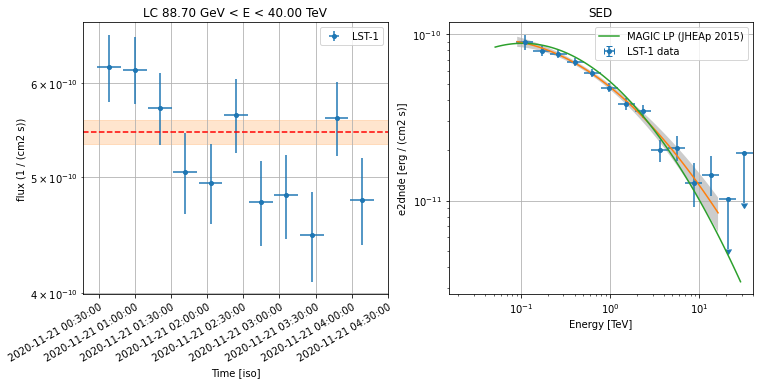

In [61]:
plt.figure(figsize=(12,5))

plt.subplot(121)
flux_points_lc.plot(sed_type="flux", **lc_kwargs)
plt.grid(which="both")
plt.title(
    f'LC {flux_points_lc.to_table(sed_type="flux", format="lightcurve")["e_min"].quantity[0][0].to(u.GeV):.2f} < ' +
    f'E < {flux_points_lc.to_table(sed_type="flux", format="lightcurve")["e_max"].quantity[0][0]:.2f}'
)
plt.axhline(
    flux_crab.to_value("cm-2 s-1"), c='red', ls='--', label=ref_label
)
plt.axhspan(
    (flux_crab - flux_crab_error).to_value("cm-2 s-1"), 
    (flux_crab + flux_crab_error).to_value("cm-2 s-1"), 
    alpha=0.2, color='tab:orange'
)


plt.subplot(122)
flux_points.plot(sed_type="e2dnde", **sed_plot_kwargs)
flux_points.reference_model.spectral_model.plot(**sed_kwargs)
flux_points.reference_model.spectral_model.plot_error(**sed_kwargs)
create_crab_spectral_model("magic_lp").plot(
    **sed_magic_ref_kwargs, label=ref_label
)
plt.legend()
plt.grid()
plt.title("SED")